# Recovery of Heard Speech Spectrograms

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Code for Augmented Lagrangian Method
def ALM(A,y,u,alpha,iters):
    m,n = np.shape(A)
    # initialise x and v of Augmented Lagrangian
    x = np.zeros(n)
    v = np.zeros(m)
    
    # do iterative updates
    err = []
    for k in range(iters):
        descent = x - alpha*u*np.dot(A.T,np.dot(A,x)-y) - alpha*np.dot(v,A)
        
        x = np.sign(descent)*np.maximum(np.abs(descent)-1,0)     # prox step
        v = v + u*(np.dot(A,x)-y)
        err.append(np.linalg.norm(np.dot(A,x)-y))
    return x,v,err

5.75922172262796e-08


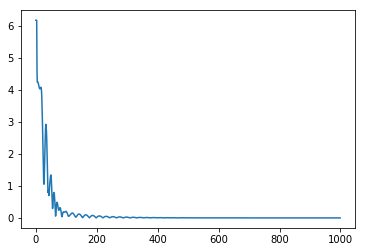

In [82]:
A = np.array([[1,-2,1,5,2,3],[3,1,4,8,4,6],[-1,1,3,1,9,5]],dtype=float)
y = np.array([-2,5,3],dtype=float)
u = 7
alpha = 8e-4
x,v,err = ALM(A,y,u,alpha,iters=1000)
plt.plot(err)
print(err[-1])